In [5]:
import numpy as np
import pykonal
import proplot as plt
from LatLon import lat_lon as ll
from obspy.geodetics.base import gps2dist_azimuth as gps
import pkg_resources
import os
from pathlib import Path



In [6]:
DATA_TYPE = np.float16

In [7]:
def clear():
    """
    Remove pre-existing files.
    """
    cmd = "rm -rf tt"
    os.system(cmd)

def loadVM():
    """
    Load velocity model
    """
    fname = pkg_resources.resource_filename(
        "pykonal",
        os.path.join("data", "marmousi2", 'marmousi2.npz')
    )
    with np.load(fname) as infile:
        vv = infile['vv']
        node_intervals = infile["node_intervals"]
    return vv, node_intervals

# Parse velocity model from "STATION0.HYP"
def parseVelocityModel(stationFile="STATION0.HYP"):
    """
    Load velocity model from "STATION0.HYP" file.
    - Inputs:
    stationFile: full name of NORDIC station file,
    - Output:
    velocityModel: a dictionary containing velocity model.
    """
    msg = "+++ Parsing velocity model ..."
    emptyLines = 0
    velocityModel = {"Vp": [], "Z": [], "VpVs": 1.73}
    with open(stationFile) as f:
        for l in f:
            if not l.strip():
                emptyLines += 1
            if emptyLines == 2 and l.strip():
                Vp, Z = [float(x) for x in l.split()[:2]]
                velocityModel["Vp"].append(Vp)
                velocityModel["Z"].append(Z)
            if emptyLines == 3 and l.strip():
                VpVs = float(l[16:20])
                velocityModel["VpVs"] = VpVs
                break
    return velocityModel

def parseStation(stationFile="STATION0.HYP"):
    """
    Read station information from "STATION0.HYP" file.
    - Inputs:
    stationFile: full name of NORDIC station file,
    - Output:
    stations: a dictionary containing stations information.
    """    
    msg = "+++ Parsing station information ..."
    emptyLines = 0
    stations = {"Code": [], "Lat": [], "Lon": [], "Elv": []}
    with open(stationFile) as f:
        for l in f:
            if not l.strip():
                emptyLines += 1
            if emptyLines == 1 and l.strip():
                code = l[:6].strip()
                lat = ll.Latitude(degree=int(
                    l[6:8]), minute=float(l[8:13])).decimal_degree
                lon = ll.Longitude(degree=int(
                    l[15:17]), minute=float(l[17:22])).decimal_degree
                elv = float(l[23:27])
                for key, value in zip(["Code", "Lat", "Lon", "Elv"], [code, lat, lon, elv]):
                    stations[key].append(value)
    return stations

def makeVelocityGrid(vm, nXnYnZ, node_intervals=(1., 1., 1.), min_coords=(0. ,0. ,0.), df=0):
    """
    Make velocity grid for P and S velocities.
    - Inputs:
    vm: a dictionary containing 1D velocity model,
    nXnYnZ: number of grid points in x,y and Z directions,
    node_intervals: grid inverval in x,y,z directions,
    min_coords: origin of the computional grid,
    df: decimation factor which is power of 2.
    - Outputs:
    solverP: P velocity grid,
    solverS: S velocity grid.
    """
    vgP = np.ones((nXnYnZ), dtype=DATA_TYPE)
    maxZ = nXnYnZ[2] * node_intervals[2]
    Vp, Z, VpVs = [v for _,v in vm.items()]
    for vp, z in zip(Vp, Z):
        indx = int(z * 1/node_intervals[2])
        if z >= maxZ:
            errMsg = "Velocity interface ({0}km) exceeds number of grids ({1}km) in Z direction!".format(z, maxZ)
            raise RuntimeError(errMsg)
        vgP[:, :, indx:] = vp
    df = 2**df
    VG = vgP[::df, :, ::df]
    node_intervals = np.array(node_intervals) * df
    # P velocity
    solverP = pykonal.EikonalSolver(coord_sys="cartesian")
    solverP.velocity.min_coords = min_coords
    solverP.velocity.node_intervals = node_intervals
    solverP.velocity.npts = VG.shape
    solverP.velocity.values = VG        
    # S velocity
    solverS = pykonal.EikonalSolver(coord_sys="cartesian")
    solverS.velocity.min_coords = min_coords
    solverS.velocity.node_intervals = node_intervals
    solverS.velocity.npts = VG.shape
    solverS.velocity.values = VG/VpVs
    return solverP.velocity, solverS.velocity

def TravelTimeTable(solver, src_idx, saveIn):
    """
    Given velocity grid, it computes travel times by specefying source index
    - Inputs:
    VG: 3D velocity grid,
    src_idx: source location based on computional grid index,
    min_coords: origin of the computional grid,
    node_intervals: intervals between computional grid points in x,y and z,
    df: decimation factor, which will be power of 2.
    - Outputs:
    travel time tables will be written to disk.
    """
    solver.traveltime.values[src_idx] = 0
    solver.unknown[src_idx] = False
    solver.trial.push(*src_idx)
    solver.solve()
    solver.traveltime.to_hdf(saveIn)

def creatTTFiles(velocity, df, velocityType):
    """
    Creating travel time table files.
    - Inputs:
    velocity: velocity object returned from pykonal,
    df: decimation factor,
    velocityType: P or S,
    - Outputs:
    None: nothing will be returned
    """
    clear()
    X = velocity.nodes[:, 0, :, 0][:,0]
    Z = velocity.nodes[:, 0, :, 2][0,:]
    for iz,z in enumerate(Z):
        ttPath = Path(os.path.join("tt", "df{df:003d}_dep{z:003d}".format(df=df, z=int(z))))
        ttPath.mkdir(parents=True, exist_ok=True) 
        for ix,x in enumerate(X):   
            src_idx = (ix ,0 , iz)
            solver = pykonal.EikonalSolver(coord_sys="cartesian")
            solver.velocity.min_coords = velocity.min_coords
            solver.velocity.node_intervals = velocity.node_intervals
            solver.velocity.npts = velocity.npts
            solver.velocity.values = velocity.values
            saveIn = os.path.join(ttPath, "dis{d:003d}{vt:s}.hdf5".format(d=int(x), vt=velocityType))
            TravelTimeTable(solver, src_idx, saveIn)

def extractTT(solver, recivers=[]):
    """
    Extract travel time from given computional grid
    - Inputs:
    solver: an object returned from "TravelTimeGrid" function
    recivers: list of desired station points (x,y,z) for getting travel times.
    - Outputs:
    tt: list of calculated travel times for desired station points.
    """
    tt = map(solver.traveltime.value, recivers)
    return tt


def plotter(hdf5File, velocity, points=[]):
    """
    A simple plotter for visualizing the 2D velocity and travel time grids.
    It also can plot one ray geometry from source if the ending point is given.
    - Inputs:
    solver: an object returned from "TravelTimeGrid" function
    point: list of ending points (x,y,z)
    - Output:
    a pdf file named "VG.pdf"
    """
    traveltime = pykonal.fields.read_hdf(hdf5File)
    X = velocity.nodes[:, 0, :, 0]
    Y = velocity.nodes[:, 0, :, 1]
    Z = velocity.nodes[:, 0, :, 2]
    figArray = [
        [1],
        [2],
        [3]
    ]
    fig = plt.figure()
    # VELOCITY MODEL
    axs = fig.subplots(figArray)
    axs.format(abc=True, abcloc="ul", xlabel="X (km)", ylabel="Z (km)")
    im1 = axs[0].pcolormesh(
        X, Z, velocity.values[:, 0, :], cmap=plt.Colormap("hot"))
    axs[0].colorbar(im1, loc="r", label="Vp (km/s)", reverse=True, maxn=5)
    axs[0].invert_yaxis()
    # TRAVEL TIME FIELD
    axs[0].set_aspect("equal")
    im2 = axs[1].pcolormesh(
    X, Z, traveltime.values[:, 0, :], cmap=plt.Colormap("jet"))
    axs[1].colorbar(im2, loc="r", label="P-time (s)", maxn=5)
    axs[1].contour(X, Z, traveltime.values[:, 0, :], colors="k", ls="--", lw=.1,
                   levels=20)
    axs[1].invert_yaxis()
    # RAY-PATH
    for point in points:
        ray = traveltime.trace_ray(point)
        if len(ray) == 1:
            src_idx = (0,0,0)
            src = traveltime.nodes[src_idx]
            axs[2].plot([src[0], ray[0, 0]], [
                        src[2], ray[0, 2]], autoreverse=False)
        else:
            axs[2].plot(ray[:, 0], ray[:, 2], autoreverse=False)
    axs[2].invert_yaxis()

    fig.save("VG.png")

def mapStation2Origin(stations, origin=(54.00, 34.00)):
    results = []
    for x, y in zip(stations["Lon"], stations["Lat"]):
        d = gps(origin[1], origin[0], y, x)[0]*1e-3
        newPoint = np.array([d, 1.0, 0.0])
        results.append(newPoint)
    return results


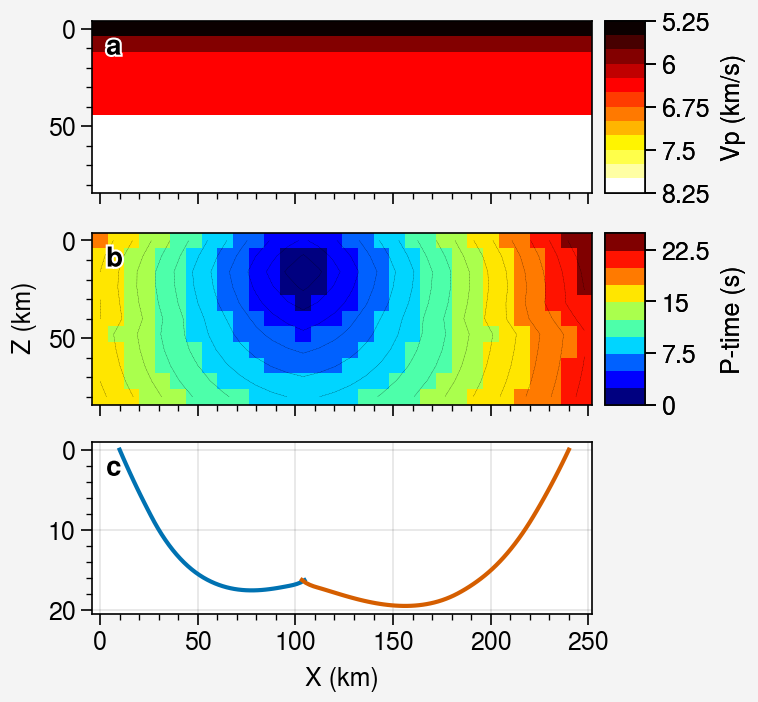

In [8]:
# Running section

# - Load velocity
vm = parseVelocityModel(stationFile="../event/STATION0.HYP")
stations = parseStation(stationFile="../event/STATION0.HYP")
# vv, node_intervals = loadVM()
# vv = vv.swapaxes(1, 2)

# - Define velocity grid
nXnYnZ = 251, 1, 81
min_coords = (0.0, 0.0, 0.0)
node_intervals = 1.0, 1.0, 1.0
decimationFactor = 3
velocity_P, velocity_S = makeVelocityGrid(vm, nXnYnZ, node_intervals, min_coords, decimationFactor)

# - Compute travel time tables for range of sources in X znd Z directions
creatTTFiles(velocity_P, decimationFactor, "P")

# src_idx = (20, 0, 5)
# solverP = TravelTimeGrid(solver_P, src_idx)

# recivers = mapStation2Origin(stations, origin=(54.00, 34.00))
recivers = [np.array([10., 1., 0.]), np.array([240., 1., 0.])]
# tt = extractTT(solver, recivers)
# plotter("tt/df003_dep016/dis104P.hdf5", velocity_P, recivers)
